In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade

In [2]:
%%time

import gc
import os
import string
import re
import warnings
warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_core.losses import SparseCategoricalCrossentropy
from keras_nlp.models import BertClassifier, BertPreprocessor
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

Using TensorFlow backend
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 8.23 s, sys: 1.5 s, total: 9.73 s
Wall time: 16.2 s


True

In [3]:
class Cfg:
    # DataFrames
    train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', index_col=0)
    test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
    sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
    
    # TF-IDF
    feature = 'text'
    target = 'target'
    language = 'english'
    stop_words = stopwords.words(language)
    punct = string.punctuation
    
    # Test size & Seed
    seed = 42
    test_size = 0.2
    
    # DL
    model = "bert_base_en_uncased"
    batch_size = 32
    n_epochs = 2
    lr = 1e-5
    n_classes = 2
    seq_length = 150
    metrics = ["accuracy"]
    callback = EarlyStopping(monitor='loss', patience=3)

In [4]:
%%time
df = Cfg.train

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


In [5]:
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


CPU times: user 31.6 ms, sys: 1.07 ms, total: 32.7 ms
Wall time: 39.8 ms


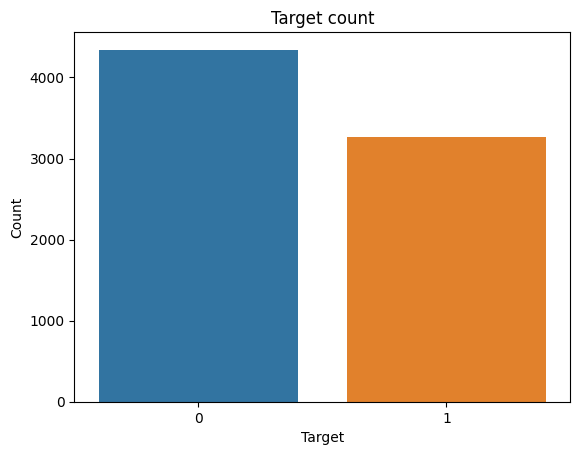

In [6]:
%%time
ax = sns.countplot(df, x=Cfg.target);
ax.set_title('Target count');
ax.set_xlabel('Target');
ax.set_ylabel('Count');

CPU times: user 934 ms, sys: 6.89 ms, total: 941 ms
Wall time: 940 ms


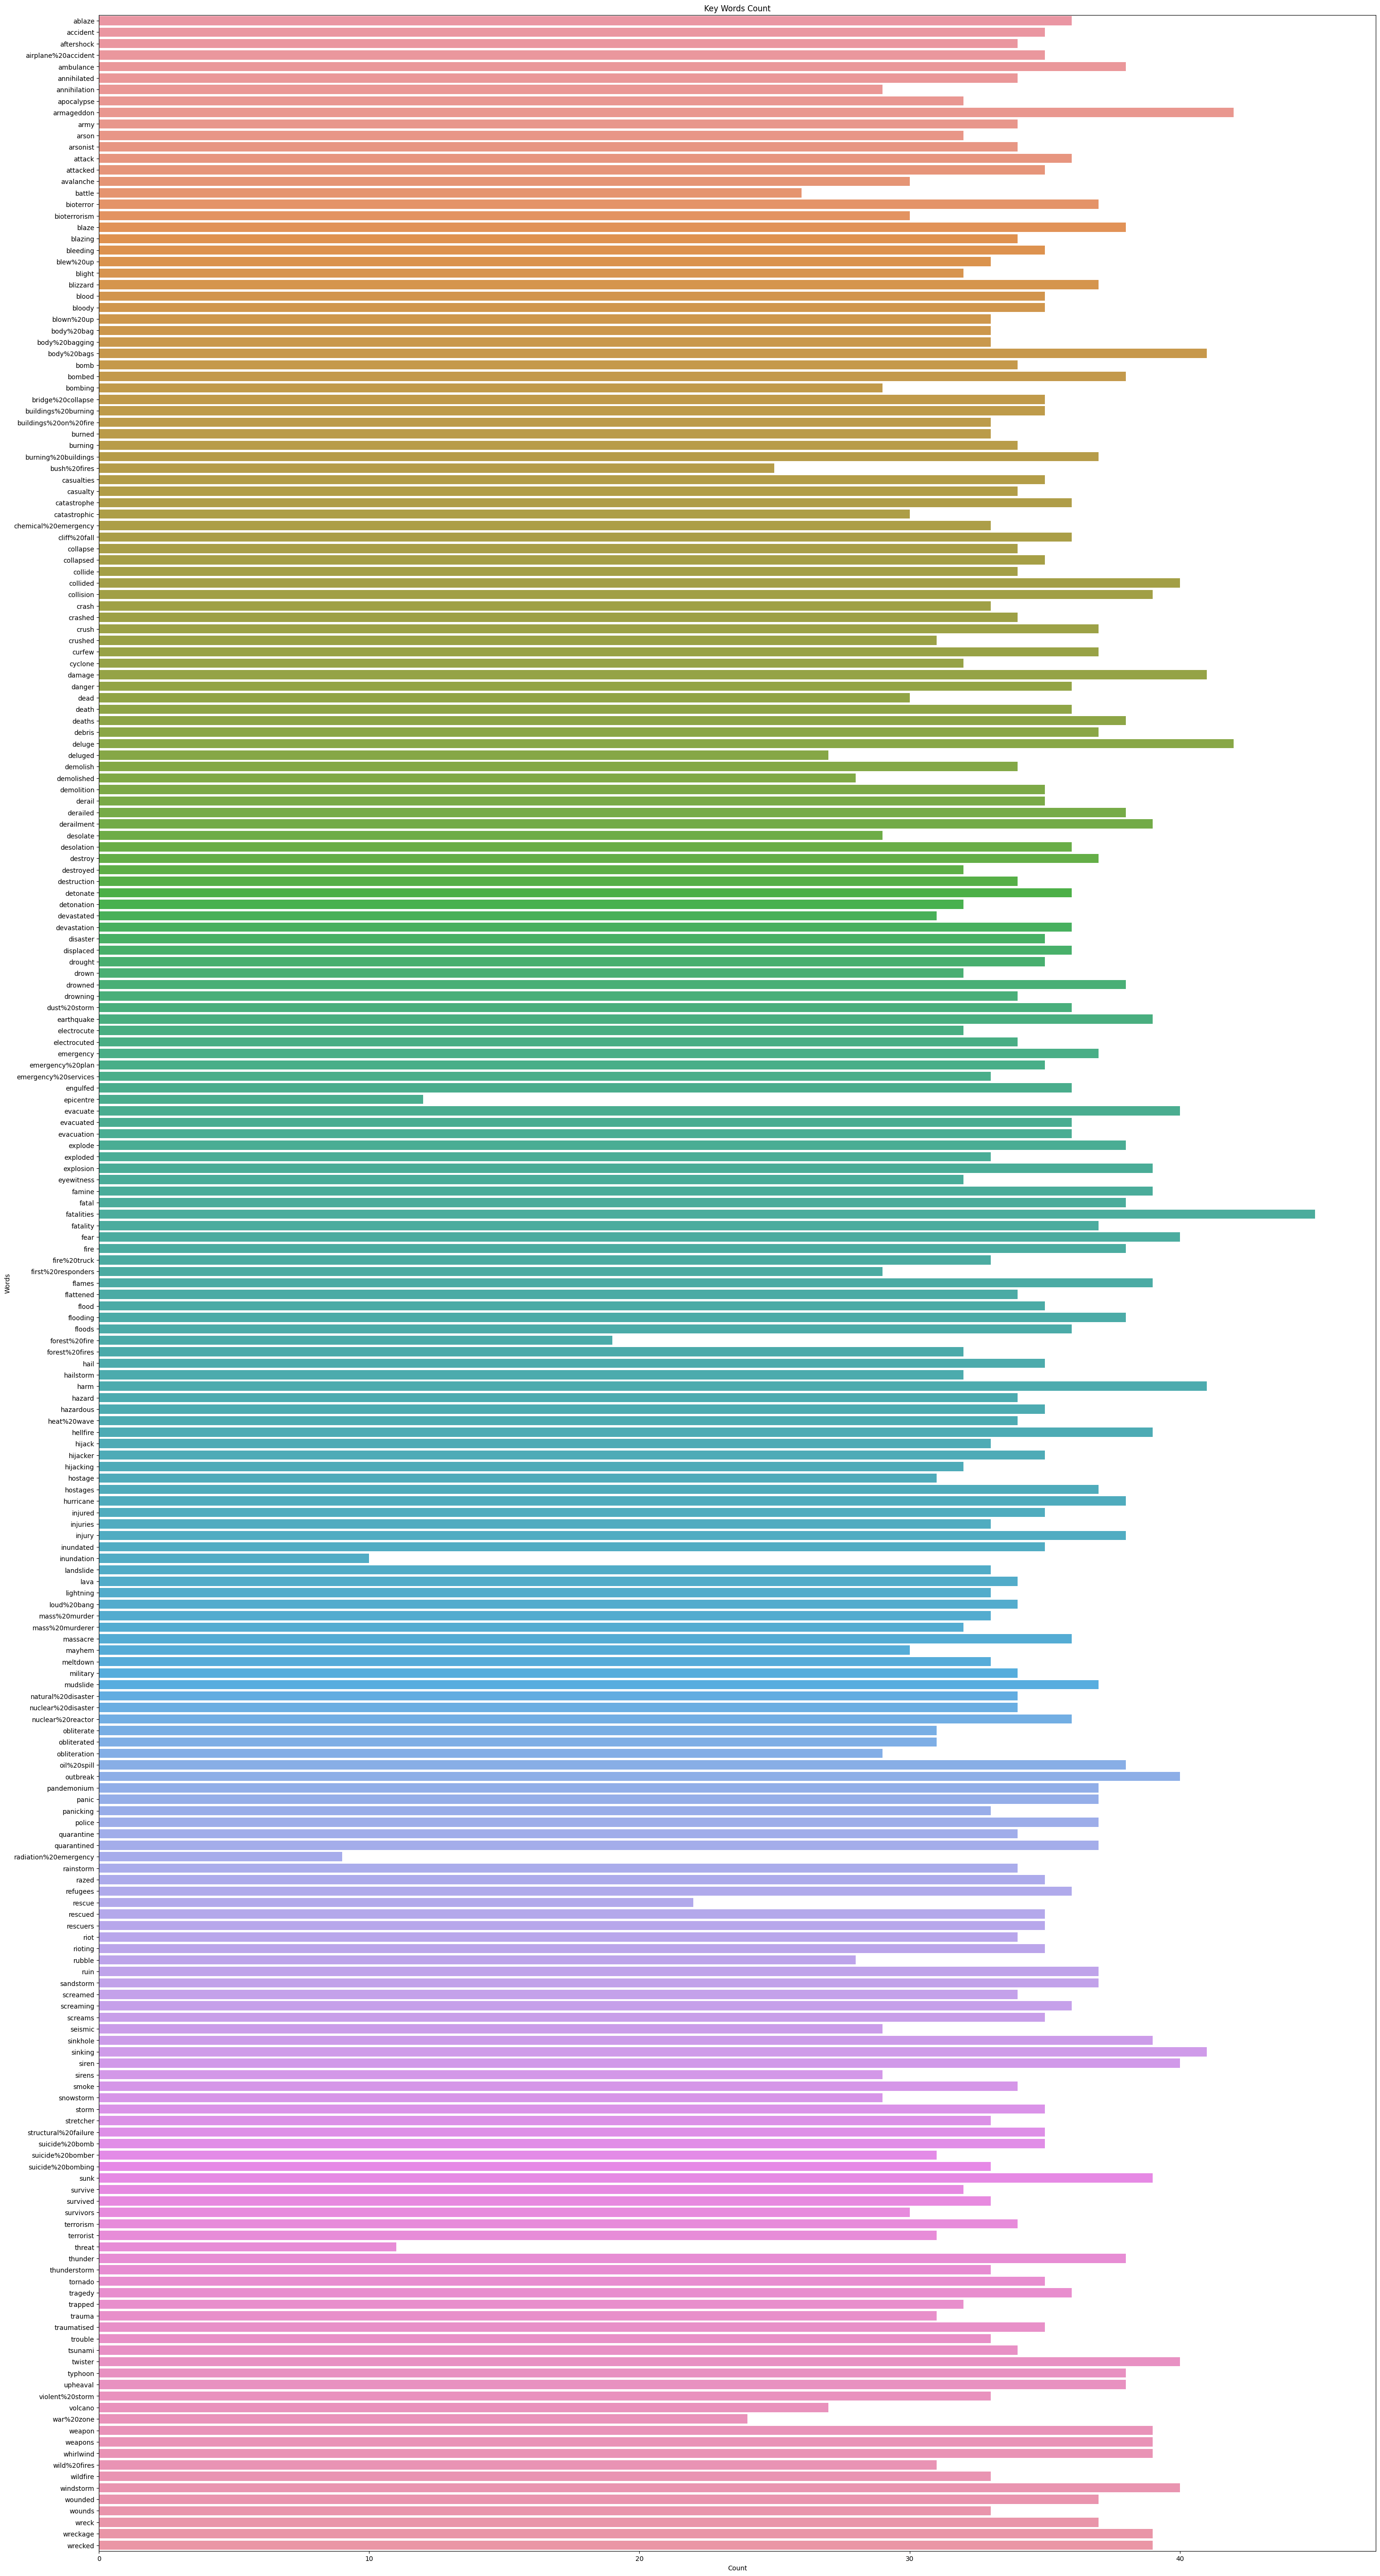

In [7]:
%%time
fig, ax = plt.subplots(figsize=(35, 70))
ax = sns.countplot(df, y='keyword', orient='h');
ax.set_title('Key Words Count');
ax.set_xlabel('Count');
ax.set_ylabel('Words');

In [8]:
sentence_example = df.iloc[1][Cfg.feature]
tokens = word_tokenize(sentence_example, language=Cfg.language)
tokens_no_punctuation = [i.lower() for i in tokens if i not in Cfg.punct]
stop_words = Cfg.stop_words
tokens_no_punctuation_and_stopwords = [i for i in tokens_no_punctuation if i not in stop_words]

In [9]:
def tokenize(sentence: str):
    tokens = word_tokenize(sentence, language=Cfg.language)
    tokens = [i.lower() for i in tokens if i not in Cfg.punct]
    stop_words = Cfg.stop_words
    tokens = [i for i in tokens if i not in stop_words]
    return tokens

In [10]:
print(f'Initial sentence: {sentence_example}')
print('-----------------------------')
print(f'Tokens with no punctuation and stopwords: {tokenize(sentence_example)}')

Initial sentence: Forest fire near La Ronge Sask. Canada
-----------------------------
Tokens with no punctuation and stopwords: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']


In [11]:
%%time
train_df, val_df = train_test_split(df, test_size=Cfg.test_size, 
                                    shuffle=True, random_state=Cfg.seed)

CPU times: user 2.61 ms, sys: 935 µs, total: 3.54 ms
Wall time: 3.21 ms


## TF-IDF Baseline

In [12]:
%%time
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize(x))
features = vectorizer.fit_transform(train_df[Cfg.feature])
features_val = vectorizer.transform(val_df[Cfg.feature])

CPU times: user 2.68 s, sys: 7.73 ms, total: 2.69 s
Wall time: 2.7 s


In [13]:
%%time
model_pipeline = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize(x))),
                           ('model', LogisticRegression(random_state=Cfg.seed))])
model_pipeline.fit(train_df[Cfg.feature], train_df[Cfg.target])
tf_idf_preds = model_pipeline.predict(val_df[Cfg.feature])

CPU times: user 3.71 s, sys: 1.19 s, total: 4.9 s
Wall time: 3.3 s


In [14]:
print(f"TF-IDF accuracy score: {accuracy_score(val_df[Cfg.target], tf_idf_preds)}")
print('-----------------------------')
print(f"TF-IDF precision score: {precision_score(val_df[Cfg.target], tf_idf_preds)}")
print('-----------------------------')
print(f"TF-IDF recall score: {recall_score(val_df[Cfg.target], tf_idf_preds)}")
print('-----------------------------')
print(f"TF-IDF f1 score: {f1_score(val_df[Cfg.target], tf_idf_preds)}")

TF-IDF accuracy score: 0.788575180564675
-----------------------------
TF-IDF precision score: 0.7883597883597884
-----------------------------
TF-IDF recall score: 0.6887519260400616
-----------------------------
TF-IDF f1 score: 0.7351973684210527


CPU times: user 50.4 ms, sys: 1.03 ms, total: 51.4 ms
Wall time: 51.1 ms


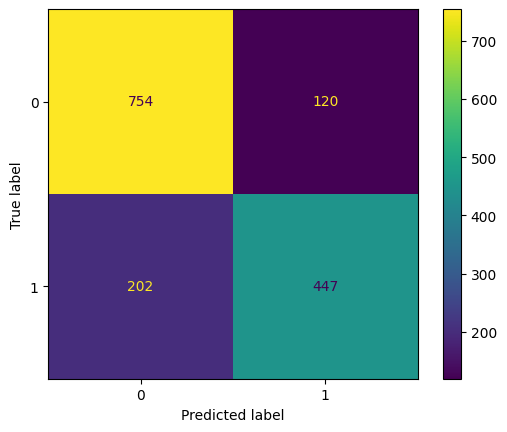

In [15]:
%%time
ConfusionMatrixDisplay.from_predictions(val_df[Cfg.target], tf_idf_preds);

In [16]:
%%time
sample = Cfg.sample
sample.head()

CPU times: user 121 µs, sys: 22 µs, total: 143 µs
Wall time: 148 µs


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [17]:
%%time
test = Cfg.test

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [18]:
%%time
sample[Cfg.target] = model_pipeline.predict(test[Cfg.feature])
sample.to_csv('tf_idf_submission.csv', index=False)

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.2 s


## DistilBERT

In [19]:
%%time
preprocessor = BertPreprocessor.from_preset(Cfg.model, 
                                            sequence_length=Cfg.seq_length)
bert = BertClassifier.from_preset(Cfg.model, 
                                  preprocessor=preprocessor, 
                                  num_classes=Cfg.n_classes)
bert.summary()

438162680/438162680 [==============================] - 2s 0us/step


Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     109,482,240 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 8.73 s, sys: 2.21 s, total: 10.9 s
Wall time: 13.1 s


In [20]:
%%time
bert.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(Cfg.lr),
    metrics=Cfg.metrics  
)

history = bert.fit(x=train_df[Cfg.feature],
                   y=train_df[Cfg.target],
                   batch_size=Cfg.batch_size,
                   epochs=Cfg.n_epochs, 
                   validation_data=(val_df[Cfg.feature],
                                    val_df[Cfg.target]),
                   callbacks=[Cfg.callback]
                        )

Epoch 1/2
191/191 [==============================] - 253s 1s/step - loss: 0.4792 - accuracy: 0.7829 - val_loss: 0.3899 - val_accuracy: 0.8431
Epoch 2/2
191/191 [==============================] - 206s 1s/step - loss: 0.3497 - accuracy: 0.8598 - val_loss: 0.3926 - val_accuracy: 0.8424
CPU times: user 4min 30s, sys: 43.4 s, total: 5min 13s
Wall time: 7min 44s


In [21]:
%%time
y_pred_train = bert.predict(train_df[Cfg.feature])
y_pred_val = bert.predict(val_df[Cfg.feature])

48/48 [==============================] - 19s 382ms/step
CPU times: user 27.3 s, sys: 2.23 s, total: 29.6 s
Wall time: 1min 36s


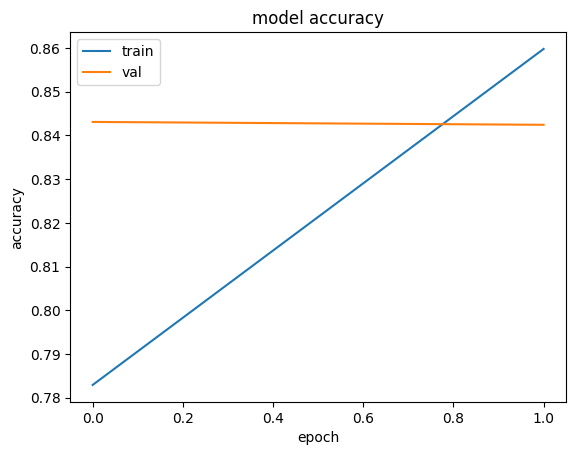

In [22]:
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'val'], loc='upper left');

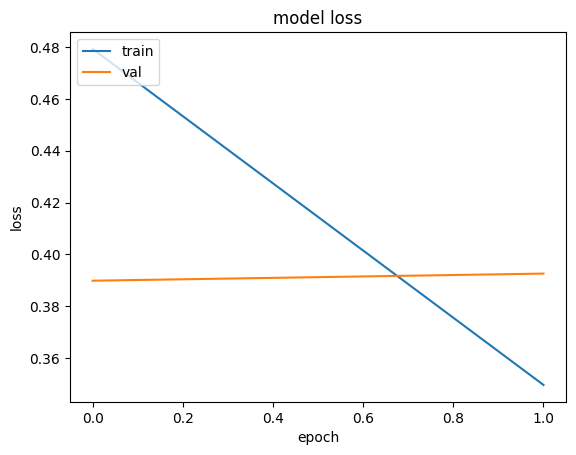

In [23]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title('model loss');
plt.ylabel('loss');
plt.xlabel('epoch');
plt.legend(['train', 'val'], loc='upper left');

In [24]:
bert_preds = np.argmax(y_pred_val, axis=1)
print(f"BERT accuracy score: {accuracy_score(val_df[Cfg.target], bert_preds)}")
print('-----------------------------')
print(f"BERT precision score: {precision_score(val_df[Cfg.target], bert_preds)}")
print('-----------------------------')
print(f"BERT recall score: {recall_score(val_df[Cfg.target], bert_preds)}")
print('-----------------------------')
print(f"BERT f1 score: {f1_score(val_df[Cfg.target], bert_preds)}")

BERT accuracy score: 0.8424162836506894
-----------------------------
BERT precision score: 0.8391376451077943
-----------------------------
BERT recall score: 0.7796610169491526
-----------------------------
BERT f1 score: 0.8083067092651757


CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 51.1 ms


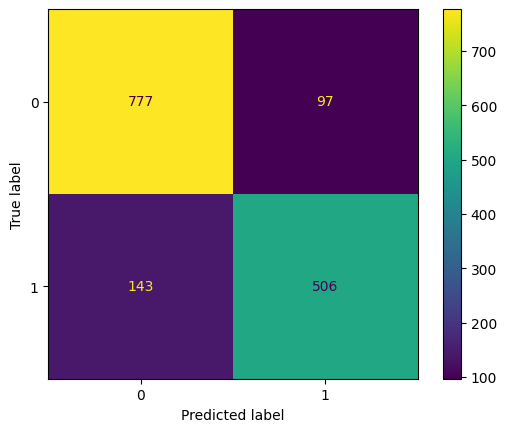

In [25]:
%%time
ConfusionMatrixDisplay.from_predictions(val_df[Cfg.target], bert_preds);

In [26]:
%%time
sample[Cfg.target] = np.argmax(bert.predict(test[Cfg.feature]), axis=1)

102/102 [==============================] - 40s 388ms/step
CPU times: user 11.7 s, sys: 937 ms, total: 12.7 s
Wall time: 41.7 s


In [27]:
%%time
sample.to_csv("submission.csv", index=False)

CPU times: user 7.81 ms, sys: 953 µs, total: 8.76 ms
Wall time: 8.28 ms


In [28]:
Cfg.lr = 2e-5  # Adjusted learning rate
Cfg.n_epochs = 4  # Increased number of epochs


In [29]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df[Cfg.target]), y=train_df[Cfg.target])
class_weight_dict = dict(enumerate(class_weights))

# Use these weights in training
history = bert.fit(
    x=train_df[Cfg.feature],
    y=train_df[Cfg.target],
    batch_size=Cfg.batch_size,
    epochs=Cfg.n_epochs, 
    validation_data=(val_df[Cfg.feature], val_df[Cfg.target]),
    callbacks=[Cfg.callback],
    class_weight=class_weight_dict
)


Epoch 1/4
191/191 [==============================] - 215s 1s/step - loss: 0.2887 - accuracy: 0.8892 - val_loss: 0.4029 - val_accuracy: 0.8450
Epoch 2/4
191/191 [==============================] - 206s 1s/step - loss: 0.2308 - accuracy: 0.9197 - val_loss: 0.4426 - val_accuracy: 0.8345
Epoch 3/4
191/191 [==============================] - 206s 1s/step - loss: 0.1832 - accuracy: 0.9351 - val_loss: 0.5285 - val_accuracy: 0.8306
Epoch 4/4
191/191 [==============================] - 206s 1s/step - loss: 0.1439 - accuracy: 0.9532 - val_loss: 0.5711 - val_accuracy: 0.8260


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Cfg.callback = [
    EarlyStopping(monitor='val_loss', patience=2),  # Stops training when a monitored quantity has stopped improving
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)  # Saves the best model
]


In [31]:
# Example using DistilBERT, which is a lighter version of BERT
Cfg.model = "distilbert_base_uncased"
